In [237]:
import json
import os
import math

import cv2
import matplotlib
import numpy as np
import pandas as pd
from keras.layers import Convolution2D, ELU, Flatten, Dropout, Dense, Lambda, Activation,MaxPooling2D
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline
matplotlib.style.use('ggplot')

# TARGET_SIZE = (64, 64)
TARGET_SIZE_COL, TARGET_SIZE_ROW = 64, 64
BATCH_SIZE = 32

image_dir = './data/'
driving_log_csv = './data/driving_log.csv'
model_json = 'model.json'
model_weights = 'model.h5'

In [238]:
class ProcessImage:
    def __init__(self, image_path, steering):
        self.image_path = image_path
        self.steering = steering
        self.image = cv2.imread(image_path.strip())
        # if self.image is None:

    def process_none(self):
        return self.image, self.steering

    def pre_process(self):
        image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        pre_process_img, steering = self.augment_brightness(image)
        pre_process_img, steering = self.crop_and_resize(pre_process_img)
        return pre_process_img, self.steering

    def flip_image_vertical(self, image=None, prob=0.5):
        # decide whether to horizontally flip the image:
        # This is done to reduce the bias for turning left that is present in the training data
        if image is None:
            image = self.image

        image = np.array(self.image)
        flip_prob = np.random.random()
        if flip_prob > prob:
            # flip the image and reverse the steering angle
            self.steering *= -1
            image = cv2.flip(image, 1)

        return image, self.steering

    def crop_and_resize(self, image=None):
        if image is None:
            image = self.image

        shape = image.shape
        image = image[math.floor(shape[0] / 5):shape[0] - 25, 0:shape[1]]
        image = cv2.resize(image, (TARGET_SIZE_COL, TARGET_SIZE_ROW), interpolation=cv2.INTER_AREA)
        return image, self.steering

    def augment_brightness(self, image=None):
        if image is None:
            image = self.image

        # convert to HSV so that its easy to adjust brightness
        bright_modified_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # randomly generate the brightness reduction factor
        # Add a constant so that it prevents the image from being completely dark
        random_bright = .25 + np.random.uniform()

        # Apply the brightness reduction to the V channel
        bright_modified_img[:, :, 2] = bright_modified_img[:, :, 2] * random_bright

        # convert to RBG again
        bright_modified_img = cv2.cvtColor(bright_modified_img, cv2.COLOR_HSV2RGB)
        return bright_modified_img, self.steering

In [239]:
# load some images for display
# [center,left,right,steering,throttle,brake,speed]
# driving_log_csv = './data/driving_log_generated.csv'
import csv
def read_driving_log():
    center_images = {}
    left_images = {}
    right_images = {}
    i =0
    with open(driving_log_csv) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if (float(row['steering']) == 0) : continue
                
            i+=1
            center_images[float(row['steering'])] = image_dir + row['center'].strip()
            left_images[float(row['steering'])] = image_dir + row['left'].strip()
            right_images[float(row['steering'])] = image_dir + row['right'].strip()
            
            if i == 5: break
        
    return center_images, left_images, right_images

center_imgs, left_imgs, right_imgs = read_driving_log()

In [240]:
import random
import numpy as np
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def plot_images(images_data, process_function):
    plt.figure(figsize=(15, 15))
    i = 0
    for steering_angle, image_path in images_data.items():
        # pre_image = pre_process(image_path)
        # pre_image, steering = ProcessImage(image_path, steering_angle).pre_process()
        pre_image, steering = process_function(image_path, steering_angle)
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(left=0.15)
        plt.imshow(pre_image)
        plt.text(0, -2, steering, fontdict=font)
        i += 1

## Actual Center Camera images along with the steering angle

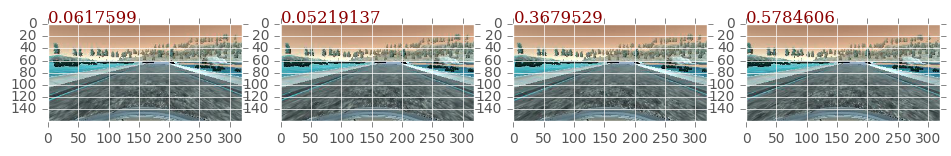

In [241]:
f = lambda image_path, steering : ProcessImage(image_path, steering).process_none()
plot_images(center_imgs, f)

## Actual Left Camera images along with the steering angle

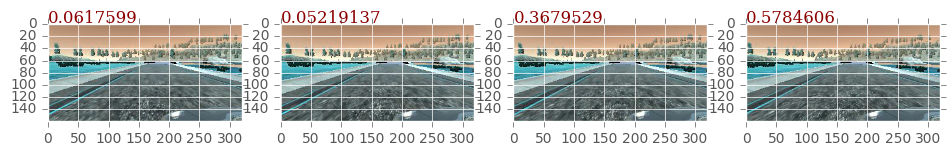

In [242]:
f = lambda image_path, steering : ProcessImage(image_path, steering).process_none()
plot_images(left_imgs, f)

## Actual Right Camera images along with the steering angle

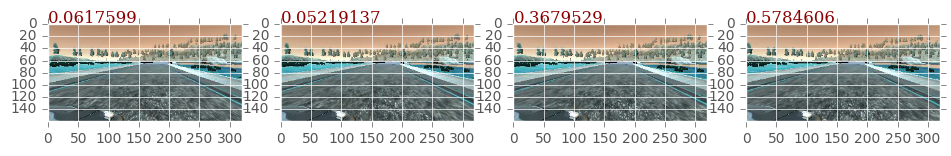

In [243]:
f = lambda image_path, steering : ProcessImage(image_path, steering).process_none()
plot_images(right_imgs, f)

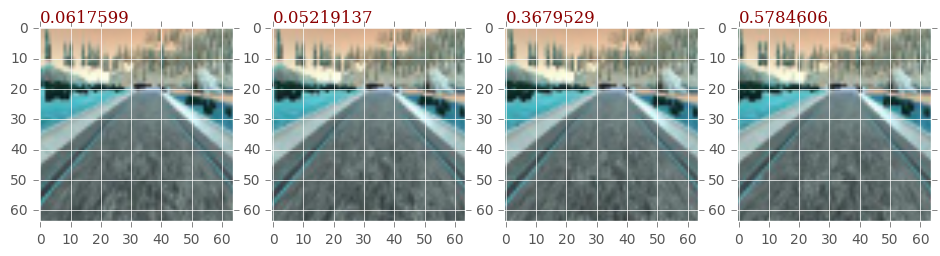

In [244]:
f = lambda image_path, steering : ProcessImage(image_path, steering).crop_and_resize()
plot_images(center_imgs, f)

In [245]:
## Visualize Brigtness Augmentation of Images

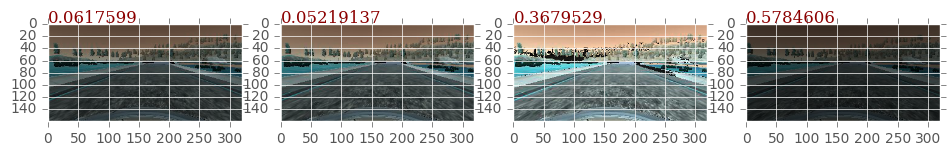

In [246]:
f = lambda image_path, steering : ProcessImage(image_path, steering).augment_brightness()
plot_images(center_imgs, f)

In [247]:
## Visualize Vertical Flipping of LEFT cImages

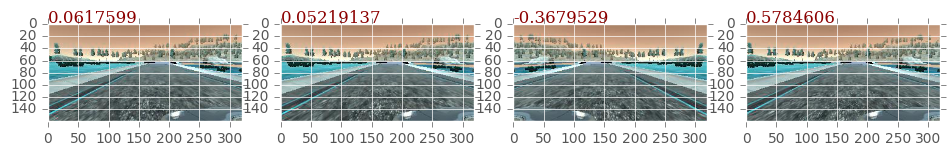

In [249]:
f = lambda image_path, steering : ProcessImage(image_path, steering).flip_image_vertical(0.01)
plot_images(left_imgs, f)

In [250]:
## Visualize All Pre-processing of LEFT, RIGHT, CENTER Images

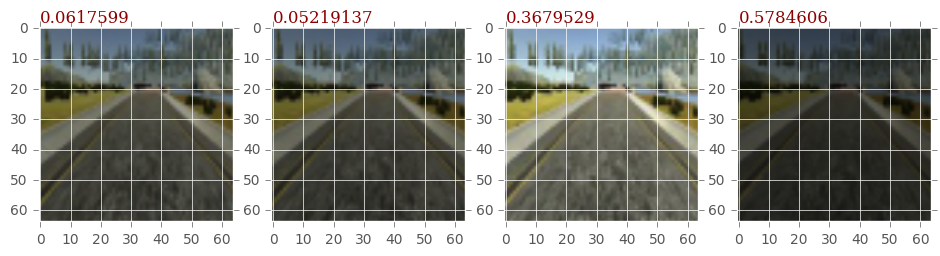

In [252]:
f = lambda image_path, steering : ProcessImage(image_path, steering).pre_process()
plot_images(center_imgs, f)

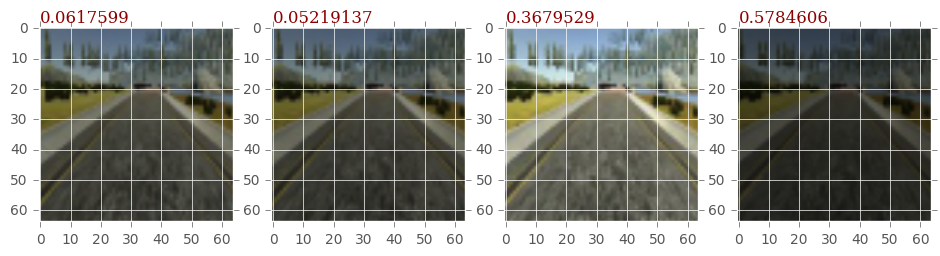

In [252]:
f = lambda image_path, steering : ProcessImage(image_path, steering).pre_process()
plot_images(center_imgs, f)

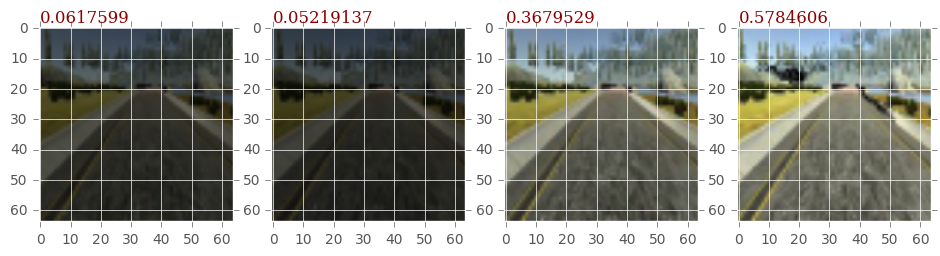

In [253]:
f = lambda image_path, steering : ProcessImage(image_path, steering).pre_process()
plot_images(left_imgs, f)

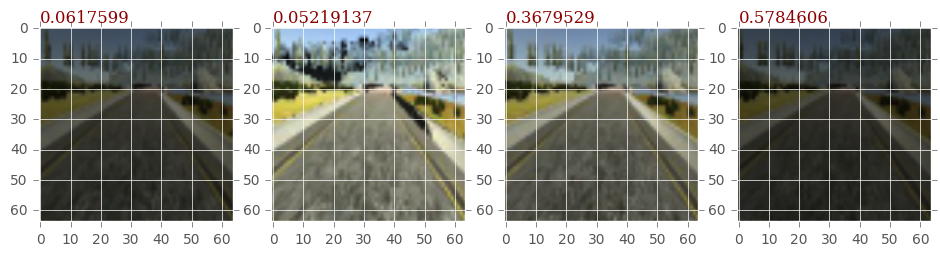

In [254]:
f = lambda image_path, steering : ProcessImage(image_path, steering).pre_process()
plot_images(right_imgs, f)

In [255]:
def get_augmented_row(row):
    steering = row['steering']

    camera_chosen = randomly_choose_camera(row)
    steering = adjust_steering_for(camera_chosen, steering)

    # image = pre_process(IMAGE_DIR + row[camera_chosen].strip())
    # image, steering = flip_image(image, steering)
    image_path = IMAGE_DIR + row[camera_chosen].strip()
    image, steering = ProcessImage(image_path, steering).pre_process()

    image = np.array(image)

    return image, steering


def adjust_steering_for(camera_chosen, steering):
    if camera_chosen == LEFT:
        steering += 0.25
    elif camera_chosen == 'right':
        steering -= 0.25

    return steering


def randomly_choose_camera(row):
    camera_chosen = CENTER
    if not (row[LEFT] and row[RIGHT]):
        camera_chosen = CENTER
    elif not (row[LEFT]):
        camera_chosen = np.random.choice([CENTER, RIGHT])
    elif not (row[RIGHT]):
        camera_chosen = np.random.choice([CENTER, LEFT])
    return camera_chosen

   ## Data generator for images

In [256]:
def get_data_generator(data_frame, batch_size=32):
    N = data_frame.shape[0]
    batches_per_epoch = N // batch_size

    i = 0
    while (True):
        start = i * batch_size
        end = start + batch_size - 1

        X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        j = 0

        # slice a `batch_size` sized chunk from the dataframe
        # and generate augmented data for each row in the chunk on the fly
        for index, row in data_frame.loc[start:end].iterrows():
            X_batch[j], y_batch[j] = get_augmented_row(row)
            j += 1

        i += 1
        if i == batches_per_epoch - 1:
            # reset the index so that we can cycle over the data_frame again
            i = 0
        yield X_batch, y_batch

## Create Data generator

In [257]:
all_driving_log_rows = pd.read_csv(driving_log_csv, usecols=[0, 1, 2, 3])

# shuffle the data
all_driving_log_rows = all_driving_log_rows.sample(frac=1).reset_index(drop=True)

# 80-20 training validation split
training_split = 0.8

num_rows_training = int(all_driving_log_rows.shape[0] * training_split)

training_data = all_driving_log_rows.loc[0:num_rows_training - 1]
validation_data = all_driving_log_rows.loc[num_rows_training:]

# release the main data_frame from memory
all_driving_log_rows = None

training_generator = get_data_generator(training_data, batch_size=BATCH_SIZE)
validation_data_generator = get_data_generator(validation_data, batch_size=BATCH_SIZE)

In [258]:
from keras.layers.normalization import BatchNormalization

nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (3, 3)
# number of hidden units in the first fully connected layer
nb_fc1=128
nb_fc2=128

model = Sequential()
model.add(Convolution2D(24, 5, 5, input_shape=(64, 64, 3), border_mode='same', subsample=(2, 2)))
model.add(ELU())

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(ELU())
model.add(Dropout(.4))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(ELU())
model.add(Dropout(.4))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(ELU())

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(ELU())

model.add(Flatten())

# Fully connected layers
model.add(Dense(1164))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dropout(.4))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(ELU())

model.add(Dense(50))
model.add(ELU())

model.add(Dense(10))
model.add(BatchNormalization())
model.add(ELU())

model.add(Dense(1))
model.add(BatchNormalization())

model.summary()


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

restart=True
if os.path.isfile(model_json) and restart:
    try:
        with open(model_json) as jfile:
            model = model_from_json(json.load(jfile))
            model.load_weights(model_weights)    
        print('loading trained model ...')
    except Exception as e:
        print('Unable to load model', model_json, ':', e)
        raise    

model.compile(optimizer=adam, loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 16, 36)    21636       elu_1[0][0]                      
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 16, 16, 36)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
#8037
samples_per_epoch = (20000 // BATCH_SIZE) * BATCH_SIZE

model.fit_generator(training_generator, validation_data=validation_data_generator,
                    samples_per_epoch=samples_per_epoch, nb_epoch=55, nb_val_samples=3000)

json_string = model.to_json()
with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)

Epoch 1/55
20000/20000 [==============================] - 265s - loss: 0.9080 - val_loss: 0.0355